In [1]:
import nbimporter
import SE2Disturbance as SE_Dist
import FlowPipe2D as fp2d
from rover_planning import RoverPlanner, simulate_rover, plot_rover_simulated, plot_rover_sim

Importing Jupyter notebook from SE2Disturbance.ipynb
Importing Jupyter notebook from FlowPipe2D.ipynb


In [2]:
from __future__ import division
import pyhull
import math
import numpy as np
from pylab import*
from pytope import Polytope
from scipy.spatial import ConvexHull
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D
import picos
import scipy.optimize
import matplotlib.pyplot as plt
import control
import slycot

In [3]:
def svd(theta):
    return (sqrt(-2/(cos(theta)-1))*abs(theta))/2
def solve_lmi(alpha, A1, A2, U1, U2, verbosity=0):
    
    prob = picos.Problem()
    P = picos.SymmetricVariable('P', (3, 3))
    P1 = P[:2, :]
    P2 = P[2, :]
    mu1 = picos.RealVariable('mu_1')
    mu2 = picos.RealVariable('mu_2')
    gam = mu1 + mu2
    block_eq1 = picos.block([
         [A1.T*P + P*A1 + alpha*P, P1.T*U1, P1.T*U2 + P2.T],
         [U1.T*P1, -alpha*mu1*np.eye(2), 0],
         [U2.T*P1 + P2, 0, -alpha*mu2]])
    block_eq2 = picos.block([
         [A2.T*P + P*A2 + alpha*P, P1.T*U1, P1.T*U2 + P2.T],
         [U1.T*P1, -alpha*mu1*np.eye(2), 0],
         [U2.T*P1 + P2, 0, -alpha*mu2]])
    prob.add_constraint(block_eq1 << 0) # dV < 0
    prob.add_constraint(block_eq2 << 0)
    prob.add_constraint(P >> 1)
    prob.add_constraint(mu1 >> 0)
    prob.add_constraint(mu2 >> 0)
    prob.set_objective('min', mu1 + mu2)
    try:
        prob.solve(options={'verbosity': verbosity})
        cost = gam.value
    except Exception as e:
        print(e)
        cost = -1
    return {
        'cost': cost,
        'prob': prob,
        'mu1': mu1.value,
        'mu2': mu2.value,
        'P': np.round(np.array(P.value), 3),
        'alpha':alpha,
        'gam': gam
    }


def solve_control_gain():
    A = np.array([
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 0]])
    B = np.array([[1, 0], [0, 0], [0, 1]])
    Q = 10*np.eye(3)  # penalize state
    R = 1*np.eye(2)  # penalize input
    K, _, _ = control.lqr(A, B, Q, R)
    K = -K  # rescale K, set negative feedback sign
    A0 = A + B@K
    return K, B, A0


def find_se2_invariant_set(value, verbosity=0):
    dA = np.array([
        [0, -1, 0],
        [1, 0, 0],
        [0, 0, 0]])    
    A0 = solve_control_gain()[2]
    A1 = A0 + (0)*dA
    A2 = A0 + pi/4*dA

    # these are the two parts of U(x), split ast U(x) = [U1, U2], where the first impacts the u, v and the last impacts the w disturbance
    # these are the zero order terms of the taylor expansion below
    # TODO: could add polytopic system with bounded input disturbance, U(x) is actually a function of the state not a constant, so this 
    # is an under approximation as is
    U1 = np.eye(2)*value # multiply singular val of U
    U2 = np.array([
        [0],
        [0]])
    
    # we use fmin to solve a line search problem in alpha for minimum gamma
    if verbosity > 0:
        print('line search')
    
    # we perform a line search over alpha to find the largest convergence rate possible
    alpha_1 = np.max(np.array([np.linalg.eig(A1)[0],np.linalg.eig(A2)[0]]))
    alpha_2 = np.max(np.linalg.eig(A2)[0])
    alpha_opt = scipy.optimize.fminbound(lambda alpha: solve_lmi(alpha, A1, A2, U1, U2, verbosity=verbosity)['cost'], x1=0.001, x2=-alpha_1, disp=True if verbosity > 0 else False)
    #print(alpha_opt1)
    #alpha_opt2 = scipy.optimize.fminbound(lambda alpha: solve_lmi(alpha, A1, A2, U1, U2, verbosity=verbosity)['cost'], x1=0.001, x2=-alpha_2, disp=True if verbosity > 0 else False)
    #print(alpha_opt2)
    #alpha_opt = np.min(np.array([alpha_opt1, alpha_opt2]))
    
    sol = solve_lmi(alpha_opt, A1, A2, U1, U2)
    prob = sol['prob']
    if prob.status == 'optimal':
        P = prob.variables['P'].value
        mu1 =  prob.variables['mu_1'].value
        mu2 =  prob.variables['mu_2'].value
        if verbosity > 0:
            print(sol)
    else:
        raise RuntimeError('Optimization failed')
        
    return sol

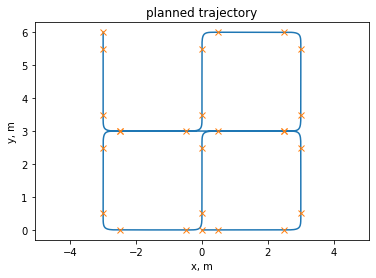

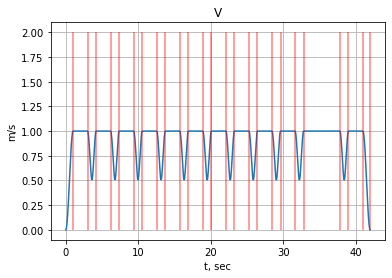

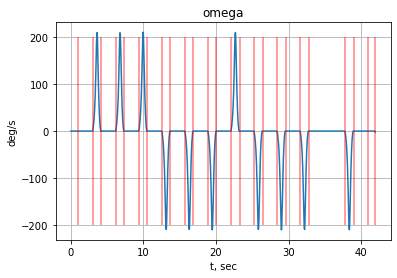

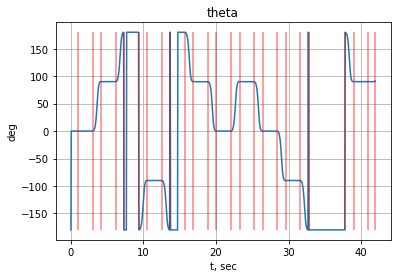

In [4]:
v  = 1
r = 0.5
planner = RoverPlanner(x=0, y=0, v=v, theta=0, r=r)
planner.goto(3, 0, v, r)
planner.goto(3, 3, v, r)
planner.goto(0, 3, v, r)
planner.goto(0, 0, v, r)
planner.goto(-3, 0, v, r)
planner.goto(-3, 3, v, r)
planner.goto(0, 3, v, r)
planner.goto(0, 6, v, r)
planner.goto(3, 6, v, r)
planner.goto(3, 3, v, r)
planner.goto(-3, 3, v, r)
planner.goto(-3, 6, v, r)
planner.stop(-3, 6)

ref_data = planner.compute_ref_data(plot=True)
x_r = ref_data['way_points'][0,:]
y_r = ref_data['way_points'][1,:]

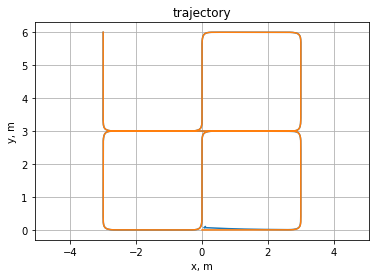

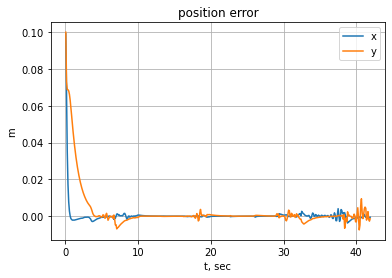

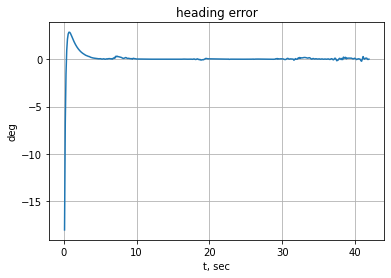

In [5]:
sol_s = find_se2_invariant_set(svd(3*pi/20)) # u, v, w1, w2
r = simulate_rover(planner, .2, 0.1, 0.1, .1, .1, pi/10, dist='maxdV', sol = sol_s, use_approx = False)
plot_rover_sim(res=r, planner=planner)

In [6]:
def se2_lie_algebra_invariant_set_points(sol, t, w1_norm, w2_norm, e0): # w1_norm (x-y direc): wind speed
    P = sol['P']
    # V = xTPx scalar
    beta = (e0.T@P@e0) # V0
    #print('V0', beta)
    val = beta*exp(-sol['alpha']*t) + sol['mu1']*w1_norm**2 + sol['mu2']*w2_norm**2 # V(t)
    #print('val', val)
    
    # 1 = xT(P/V(t))x, equation for the ellipse
    evals, evects = np.linalg.eig(P/val)
    radii = 1/np.sqrt(evals)
    R = evects@np.diag(radii)
    R = np.real(R)
    
    # draw sphere
    points = []
    n = 25
    for u in np.linspace(0, 2*np.pi, n):
        for v in np.linspace(0, 2*np.pi, 2*n):
            points.append([np.cos(u)*np.sin(v), np.sin(u)*np.sin(v), np.cos(v)])
    for v in np.linspace(0, 2*np.pi, 2*n):
        for u in np.linspace(0, 2*np.pi, n):
            points.append([np.cos(u)*np.sin(v), np.sin(u)*np.sin(v), np.cos(v)])
    points = np.array(points).T
    return R@points

In [7]:
def SE2_exp_wedge(a): 
    assert a.shape == (3,)
    alpha = a[2]
    u1 = a[0]
    u2 = a[1]
    if abs(alpha) < 0.1:
        t1 = 1 - alpha**2/6 + alpha**4/120 
        t2 = alpha/2 - alpha**3/24 - alpha**5/720 
    else:
        t1 = sin(alpha)/alpha
        t2 = (1-cos(alpha))/alpha
    x = np.array([[t1, -t2],
                  [t2, t1]])@[u1,u2]
    return array([x[0], x[1], alpha])
def se2_log(a):
    assert a.shape == (3,)
    theta = a[2]
    x = a[0]
    y = a[1]
    with np.errstate(divide='ignore',invalid='ignore'):
        a = np.where(np.abs(theta) < 1e-3, 1 - theta**2/6 + theta**4/12, np.sin(theta)/theta)
        b = np.where(np.abs(theta) < 1e-3, theta/2 - theta**3/24 + theta**5/720, (1 - np.cos(theta))/theta)
    V_inv = np.array([
        [a, b],
        [-b, a]
    ])/(a**2 + b**2)
    p = V_inv@np.array([x, y])
    return array([p[0], p[1], theta])

In [14]:
w1 = .5
w2 = .5
e = array([0, 0, 0]) # Lie Group
e0 = se2_log(e) # Lie Algebra
t = 0
sv = []
a_theta = []
Mt = []
mt = []

for i in linspace(1e-5, pi, 21):
    value = svd(i)
    sol = find_se2_invariant_set(value)
    
    points = se2_lie_algebra_invariant_set_points(sol, t, w1, w2, e0) #Lie Algebra
    max_theta = points[2,:].max()
    min_theta = points[2,:].min()
    
    a_theta.append(i)
    sv.append(value)
    Mt.append(max_theta)
    mt.append(min_theta)

In [15]:
info = {'theta': a_theta, 'Singular value': sv, 'Max inv theta': Mt, 'min inv theta': mt}
print(tabulate(info, headers='keys'))

   theta    Singular value    Max inv theta    min inv theta
--------  ----------------  ---------------  ---------------
1e-05              1               0.961562        -0.962291
0.157089           1.00103         0.963441        -0.964147
0.314168           1.00412         0.964162        -0.964883
0.471247           1.00931         0.968181        -0.96888
0.628327           1.01664         0.972584        -0.973273
0.785406           1.02617         0.980745        -0.981381
0.942485           1.03799         0.987366        -0.98799
1.09956            1.05221         0.998217        -0.998784
1.25664            1.06896         1.00937         -1.0099
1.41372            1.0884          1.02342         -1.02387
1.5708             1.11072         1.04005         -1.04042
1.72788            1.13615         1.05663         -1.05694
1.88496            1.16497         1.07681         -1.07703
2.04204            1.19748         1.09853         -1.09867
2.19912            1.23406       

In [14]:
sol = find_se2_invariant_set(svd(15*pi/20))
w1 = 1
w2 = 1
e = array([0, 0, 0]) # Lie Group
e0 = se2_log(e) # Lie Algebra

t = 0
points = se2_lie_algebra_invariant_set_points(sol, t, w1, w2, e0) #Lie Algebra

exp_points = np.zeros((3,points.shape[1]))
for i in range(points.shape[1]):
    exp_points[:,i] = SE2_exp_wedge(points[:,i])

Text(0.5, 1.0, 'Invariant Set in Lie Group')

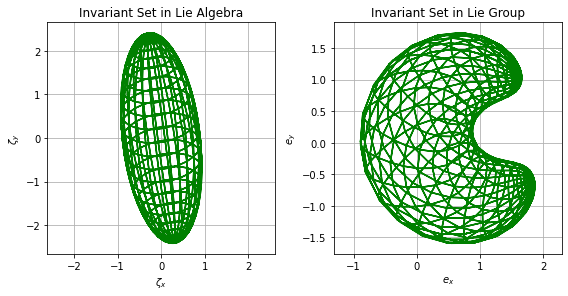

In [16]:
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
ax.plot(points[0, :], points[1, :], 'g')
ax.set_xlabel('$\\zeta_x$')
ax.set_ylabel('$\\zeta_y$')
#ax.plot(e0[0],e0[1],'ro')
plt.axis('equal')
plt.grid(True)
ax2 = plt.subplot(122)
ax2.plot(exp_points[0, :-1], exp_points[1, :-1], 'g')
#ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('$e_x$')
ax2.set_ylabel('$e_y$')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
ax.set_title('Invariant Set in Lie Algebra')
ax2.set_title('Invariant Set in Lie Group')

# plt.figure(figsize=(8,4))
# ax = plt.subplot(121)
# ax.plot(points[1, :], points[2, :], 'g')
# ax.set_xlabel('y')
# ax.set_ylabel('$\\theta$')
# plt.axis('equal')
# ax2 = plt.subplot(122)
# ax2.plot(exp_points[1, :], exp_points[2, :], 'g')
# ax2.set_xlabel('y')
# ax2.set_ylabel('$\\theta$')
# plt.axis('equal')
# plt.tight_layout()

# plt.figure(figsize=(8,4))
# ax = plt.subplot(121)
# ax.plot(points[0, :], points[2, :], 'g');
# ax.set_xlabel('x')
# ax.set_ylabel('$\\theta$')
# plt.axis('equal')
# ax2 = plt.subplot(122)
# ax2.plot(exp_points[0, :], exp_points[2, :], 'g');
# ax2.set_xlabel('x')
# ax2.set_ylabel('$\\theta$')
# plt.axis('equal')
# plt.tight_layout()

# plt.figure(figsize=(12,6))
# ax = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax.plot3D(e0[0], e0[1], e0[2], 'ro');
# ax.plot3D(points[0, :], points[1, :], points[2, :],'g');
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('$\\theta$')
# plt.axis('auto')
# ax2 = plt.subplot(122, projection='3d', proj_type='ortho', elev=40, azim=40)
# ax2.plot3D(e[0], e[1], e[2], 'ro');
# ax2.plot3D(exp_points[0, :], exp_points[1, :], exp_points[2, :], 'g');
# ax2.plot3D(e[0], e[1], e[2], 'ro');
# ax2.set_xlabel('x')
# ax2.set_ylabel('y')
# plt.axis('auto')
# plt.tight_layout()

2.0489589550273446


Text(0.5, 1.0, 'Invariant Set from LMI')

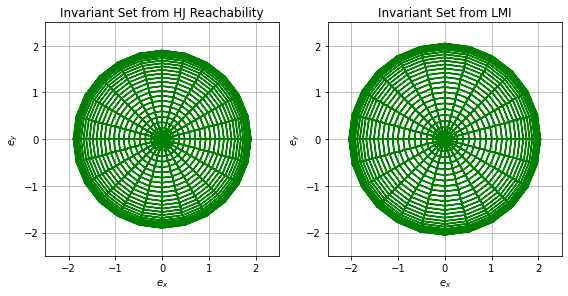

In [17]:
hj_points = hj_invariant_set_points(1.9) 
dist = np.zeros((exp_points.shape[1]))
for i in range(exp_points.shape[1]):
    dist[i] = np.sqrt(exp_points[1,i]**2 + exp_points[0,i]**2)
LG_swe_points = hj_invariant_set_points(dist.max())
print(dist.max())

plt.figure(figsize=(8,4))
ax = plt.subplot(121)
ax.plot(hj_points[0, :], hj_points[1, :], 'g');
ax.set_xlabel('$e_x$')
ax.set_ylabel('$e_y$')
#ax.plot(e0[0],e0[1],'ro')
ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])
plt.grid(True)
ax2 = plt.subplot(122)
ax2.plot(LG_swe_points[0, :-1], LG_swe_points[1, :-1], 'g');
#ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('$e_x$')
ax2.set_ylabel('$e_y$')
plt.grid(True)
ax2.set_xlim([-2.5,2.5])
ax2.set_ylim([-2.5,2.5])
plt.tight_layout()
ax.set_title('Invariant Set from HJ Reachability')
ax2.set_title('Invariant Set from LMI')

In [18]:
def rotate_point(point, angle):
    new_point = array([point[0] * cos(angle) - point[1] * sin(angle),
                 point[0] * sin(angle) + point[1] * cos(angle)])
    return new_point

In [19]:
def flowpipes2(x_r, y_r, n, e0, w1, w2, sol):
    
    nom = array([x_r,y_r]).T
    flowpipes = []
    intervalhull = []
    cp = []
    ag = []
    if len(x_r)%n == 0:
        steps = int(len(x_r)/n)
    else:
        steps = int(len(x_r)/n + 1)
    a = n      
    
    for i in range(n):
        if (steps*(i+1)) < len(x_r):
            nom_i = nom[steps*i:steps*(i+1),:] # steps*2
        else:
            nom_i = nom[steps*i:len(x_r),:]
        # Get interval hull
        hull_points = fp2d.qhull2D(nom_i)
        # Reverse order of points, to match output from other qhull implementations
        #hull_points = hull_points[::-1]
        (rot_angle, area, width, height, center_point, corner_points) = fp2d.minBoundingRect(hull_points)
        # add first corner_points to last
        #print(i, corner_points)
        corner_points = np.append(corner_points, corner_points[0].reshape(1,2), axis = 0)
        
        dx = corner_points[0][0]-corner_points[1][0]
        
        # for j in range(len(nom_i)):
        #     l = np.sqrt((nom_i[0] - nom_i[0])**2 + (center_point[1] - x0[1])**2)
#         if i == 0:
#             l = np.sqrt((center_point[0] - x0[0])**2 + (center_point[1] - x0[1])**2)
#             angle = np.arccos((center_point[0] - x0[0])/l)
#         else:
#             l = np.sqrt((center_point[0] - cp[-1][0])**2 + (center_point[1] - cp[-1][1])**2)
#             angle = np.arccos((center_point[0] - cp[-1][0])/l)
#             if np.around(angle) == 2:
#                 angle = np.arcsin((center_point[1] - cp[-1][1])/l)
#             if angle < 0:
#                 angle += 2*np.pi
        
        # choose to use width or height (don't want the one close to zero)
        if width > height:
#            print('w')
            if int(corner_points[0][0]) - int(corner_points[1][0]) == 0 or np.around(corner_points[0][0] - corner_points[1][0], decimals = 1) > 0.1:
#                print('w1')
                angle = np.arccos(np.around((corner_points[0][0]-corner_points[1][0])/width, decimals=5))
            else:
#                print('w2')
                angle = np.arccos(np.around((corner_points[0][0]-corner_points[1][0])/width, decimals=5))
        elif height > width:
#            print('h')
            if int(corner_points[0][0]) != int(corner_points[1][0]) or np.around(corner_points[0][0] - corner_points[1][0], decimals = 1) > 0.1:
#                print('h1')
                angle = np.arccos(np.around((corner_points[0][0]-corner_points[1][0])/height, decimals=5))
            else:
#                print('h2')
                angle = np.arccos(np.around((corner_points[2][0]-corner_points[1][0])/height, decimals=5))
        #fix mess up part
        if angle > 3:
            if i < int(n/3):
                angle = angle - pi
        if angle < 1:
            if i > int(n/3):
                a = i
        if i >= a:
            angle = angle + pi
        #print(angle)

        t = 0.05*i*steps
        # invariant set in se2
        points = se2_lie_algebra_invariant_set_points(sol, t, w1, w2, e0)
        
        # exp map
        exp_points = np.zeros((3,points.shape[1]))
        for i in range(points.shape[1]):
            exp_points[:,i] = SE2_exp_wedge(points[:,i])
            
        # invariant set in SE2   
        inv_points = rotate_point(exp_points, angle)
        
        P2 = Polytope(inv_points.T)
        # minkowski sum
        P1 = Polytope(corner_points) # interval hull
        P = P1 + P2 # sum
        p1_vertices = P1.V
        p_vertices = P.V
        p_vertices = np.append(p_vertices, p_vertices[0].reshape(1,2), axis = 0) # add the first point to last, or the flow pipes will miss one line
        flowpipes.append(p_vertices)
        intervalhull.append(P1.V)
        cp.append(center_point)
        ag.append(angle)
    return flowpipes, intervalhull, nom

In [21]:
def circ_inv(r):
    theta_circ = np.linspace(0, 2*np.pi, 100)
    circ = array([r*np.cos(theta_circ), r*np.sin(theta_circ)]).T
    return circ

# Flow Pipes Simulation

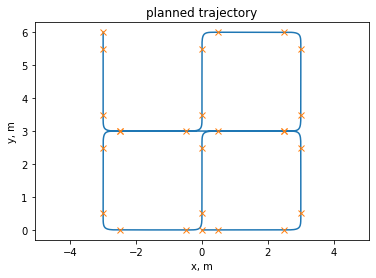

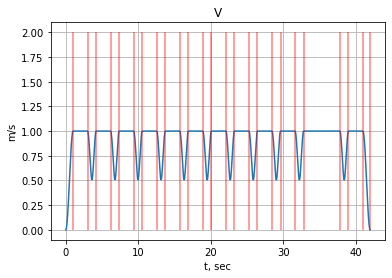

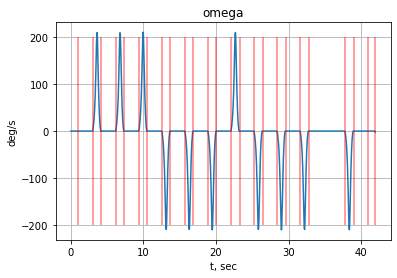

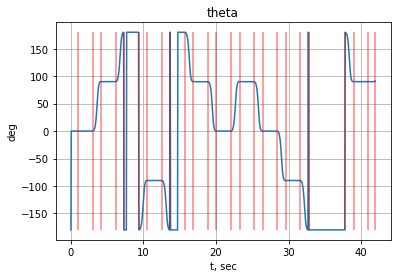

In [16]:
v  = 1
r = 0.5
planner = RoverPlanner(x=0, y=0, v=v, theta=0, r=r)
planner.goto(3, 0, v, r)
planner.goto(3, 3, v, r)
planner.goto(0, 3, v, r)
planner.goto(0, 0, v, r)
planner.goto(-3, 0, v, r)
planner.goto(-3, 3, v, r)
planner.goto(0, 3, v, r)
planner.goto(0, 6, v, r)
planner.goto(3, 6, v, r)
planner.goto(3, 3, v, r)
planner.goto(-3, 3, v, r)
planner.goto(-3, 6, v, r)
planner.stop(-3, 6)

ref_data = planner.compute_ref_data(plot=True)
x_r = ref_data['way_points'][0,:]
y_r = ref_data['way_points'][1,:]

In [24]:
# t = 40
n = 40 # number of interval hulls
# disturbances
w1 = .1
w2 = .1  
sol_s = find_se2_invariant_set(svd(3*pi/20)) # u, v, w1, w2

#ref = SE_Dist.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol1, use_approx=False)
#y_vect = ref['y']
#x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]
e0 = se2_log(array([0, 0, pi/10]))
x0 = np.array([0,0,0])

flow_pipes_LMI, intervalhull_LMI, nom = flowpipes2(x_r, y_r, n, e0, w1, w2, sol_s)

Text(0, 0.5, 'y')

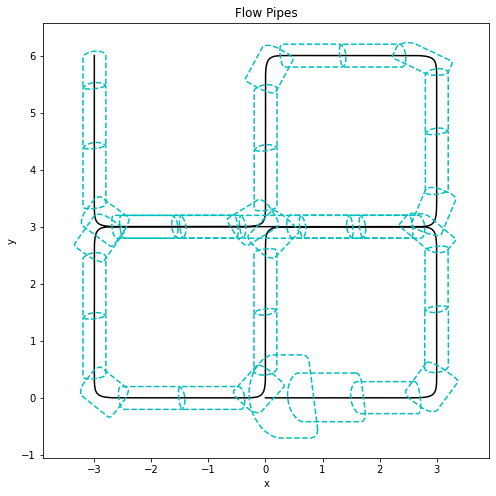

In [25]:
# flow pipes
plt.figure(figsize=(8,8))
ax = subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_LMI = ax.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='c', linestyle='--')
    #hs_ch_LMI_L = ax.plot(flow_pipes_LMI_L[facet][:,0], flow_pipes_LMI_L[facet][:,1], color='y', linestyle='--')
    #hs_ch_Hs = ax.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)

plt.axis('equal')
title('Flow Pipes')
xlabel('x')
ylabel('y')
#legend([h_nom[0], hs_ch_LMI[0], hs_ch_LMI_L[0]], ['nominal', 'flow pipe (small)', 'flow pipe (Large)'], loc=1);

Text(0, 0.5, 'y')

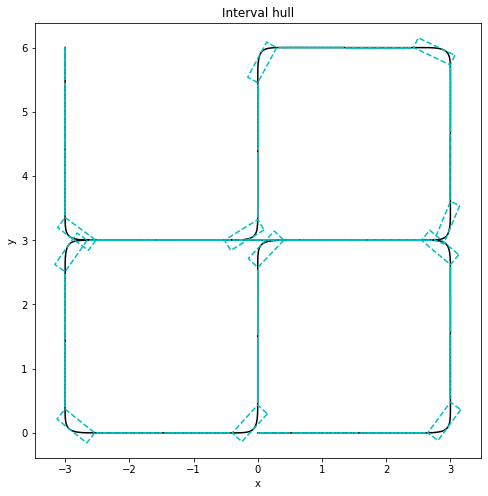

In [26]:
# interval hull
plt.figure(figsize=(8,8))
ax = subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_LMI = ax.plot(intervalhull_LMI[facet][:,0], intervalhull_LMI[facet][:,1], color='c', linestyle='--')
    #hs_ch_Ls = ax.plot(intervalhull_Ls[facet][:,0], intervalhull_Ls[facet][:,1], color='m', linestyle='--')
    #hs_ch_Hs = ax.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)

plt.axis('equal')
title('Interval hull')
xlabel('x')
ylabel('y')
#legend([h_nom[0], hs_ch_Ls[0]], ['nominal', 'interval hull'], loc=1);

# Trajectories simulation

In [27]:
# small distrubance
freq = [.02, .06, .08]#, .1, .3, .5, .7, .9]
e = []
V = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = .5
w2 = .5
sol_s = find_se2_invariant_set(svd(10*pi/20))

cnt = 0
for theta0 in np.arange(-pi/10, pi/10, pi/4):    
    for x0 in np.linspace(-.1, .1, 3):
        for y0 in np.linspace(-.1, .1, 3):
            cnt += 1
            init_e = np.array([[x0, y0, theta0]]).T
            V0 = init_e.T@sol['P']@init_e
            V.append(V0)
            e.append(init_e)
            for i, f in enumerate(freq):
                r = simulate_rover(planner, f, w1, w2, x0, y0, theta0, dist='maxdV', sol = sol_s, use_approx = False)
                #r2 = simulate_rover(planner, f, w1, w2, 0, 0, theta0, dist='square', sol= sol_s)
                legend = cnt == 1 and i == 0
                plot_rover_simulated(r, name='sine', legend=legend, save=False, linewidth = .5, color = 'g')
                #plot_rover_simulated(r2, name='square', legend=legend, save=False, linewidth = .5, color = 'b') 
                #if i == len(freq) - 1:
                    #r3 = simulate_rover(planner, f, w1, w2, 0, 0, theta0, dist='maxdV', sol= sol_s)
                    #plot_rover_simulated(r3, name='maxdV', legend= (cnt == 1), save=False, linewidth = 1, color = 'r')

i = np.array(V).argmax()
#print(e[i])
e0 = se2_log(np.array(e[i]).reshape(3,))
flow_pipes_LMI, intervalhull_LMI, nom = flowpipes2(x_r, y_r, n, e0, w1, w2, sol_s)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.6)
    
h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-', linewidth = 2)

plt.axis('equal')
title('Flow Pipes with Simulated Trajectories')
xlabel('x')
ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

KeyboardInterrupt: 

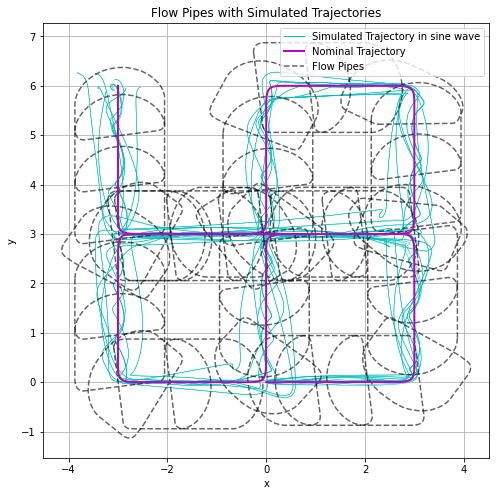

In [31]:
# large distrubance
freq = [.02, .06, .08, .1, .3, .5, .7, .9]
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = .5
w2 = .5
sol_s = find_se2_invariant_set(svd(8*pi/20))

for theta0 in np.linspace(-pi/10, pi/10, 2):
    for i in freq:
        r = simulate_rover(planner, i, w1, w2, 0, 0, theta0)
        #r2 = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='square', sol= sol_s, use_approx=False)
        if theta0 == np.pi/10 and i == freq[-1]:
            plot_rover_simulated(r, name='sine wave', legend=True, save=False, linewidth = 1, color = 'c')
            #SE_Dist.plot_simulated(r2, name='square', legend=True, save=False, linewidth = 1, color = 'y')
        else:
            plot_rover_simulated(r, name='', legend=False, save=False, linewidth = .5, color = 'c')
            #SE_Dist.plot_simulated(r2, name='', legend=False, save=False, linewidth = 1, color = 'y')

flow_pipes_LMI, intervalhull_LMI, nom = flowpipes2(x_r, y_r, n, e0, w1, w2, x0, sol1)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.6)
    
h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-', linewidth = 2)

plt.axis('equal')
title('Flow Pipes with Simulated Trajectories')
xlabel('x')
ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

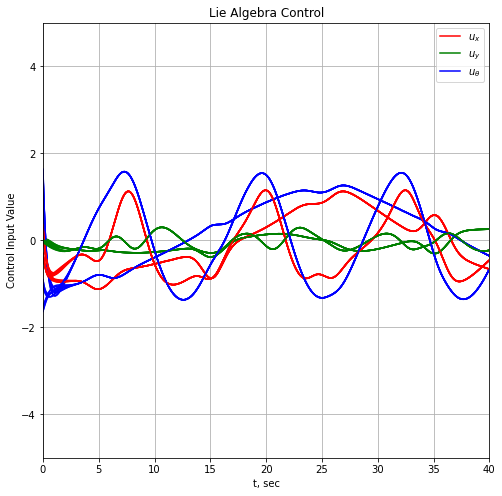

In [21]:
# small distrubance
freq = [0.02, .08]#, .06, .08]#, .01, .03, .05, .07, .09]
res = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = 1
w2 = 1
sol_s = find_se2_invariant_set(svd(15*pi/20))


for theta0 in np.linspace(-pi/10, pi/10, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
                for i in freq:
                    r = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='sine', sol= '', use_approx=False)
                    res.append(r)
                    if theta0 == np.pi/10 and x0 == .1 and y0 == .1 and i == freq[-1]:
                        SE_Dist.plot_control(r, name='sine wave', legend=True, save=False, linewidth = 1, color = 'c')
                    else:
                        SE_Dist.plot_control(r, name='', legend=False, save=False, linewidth = .5, color = 'c')

plt.xlim([0, 40])
plt.ylim([-5, 5])

plt.legend(loc=1)

[ 0.          0.         -0.31415927]
Min x: 0.0  Max x:  0.9499999999999986    Min y: -1.4792416646412479e-09  Max y:  4.491455275337635e-17
[[ 9.50000000e-01  4.33606840e-10]
 [ 2.97848951e-18 -1.47924166e-09]
 [-9.04365577e-26  4.49145528e-17]
 [ 9.50000000e-01  1.91284855e-09]
 [ 9.50000000e-01  4.33606840e-10]]
0.0
Min x: 0.9999999996977771  Max x:  1.9499999971846618    Min y: -3.798585951668644e-05  Max y:  -2.4585325924629844e-05
[[ 1.95000000e+00  9.96355020e-06]
 [ 1.00000000e+00 -1.33964186e-05]
 [ 1.00000000e+00  4.11498328e-09]
 [ 1.95000000e+00  2.33640838e-05]
 [ 1.95000000e+00  9.96355020e-06]]
0.0
Min x: 1.9999856617706948  Max x:  2.949978875730953    Min y: -0.00905547444235894  Max y:  -0.007572461469614088
[[ 2.94999198e+00  2.16109066e-03]
 [ 2.00000564e+00 -1.45100251e-03]
 [ 2.00000000e+00  3.19997451e-05]
 [ 2.94998634e+00  3.64409292e-03]
 [ 2.94999198e+00  2.16109066e-03]]
0.0044721396817777506
Min x: 2.991221615840274  Max x:  3.9400776456055366    Min y: -0

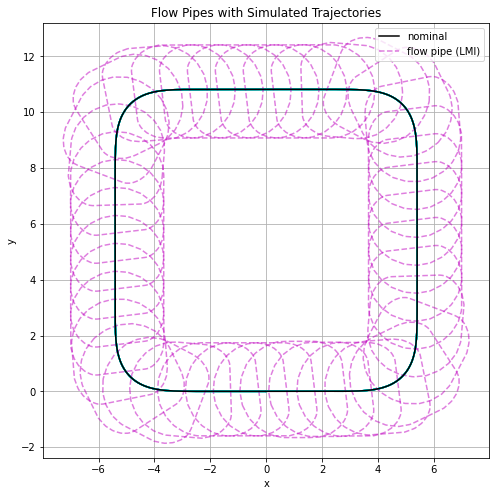

In [25]:
# large disturbance
freq = [0.02, .04, .06, .08, .01, .03, .05, .07, .09]
res = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = 1
w2 = 1  
sol_s = find_se2_invariant_set(svd(pi))


ref = SE_Dist.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol_s, use_approx=False)
y_vect = ref['y']
x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]

init_e = array([[0, 0, -pi/10]]).T 
V0 = init_e.T@sol['P']@init_e
for i in freq:
    r = SE_Dist.simulate(40, i, w1, w2, init_e[0], init_e[1], init_e[2], dist='maxdV', sol= sol_s, use_approx=False)
    SE_Dist.plot_simulated(r, color='c', name='sine wave', legend=True, save=False)
    res.append(r)
                
e0 = se2_log(init_e.reshape(3,))
print(e0)
flow_pipes_LMI, intervalhull_LMI, nom = flowpipes(ref, t, n, e0, w1, w2, sol)#flowpipes(x_r, y_r, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='m', linestyle='--', alpha = 0.5)
    
h_nom = plt.plot(nom[:,0], nom[:,1], color='k', linestyle='-')

plt.axis('equal')
title('Flow Pipes with Simulated Trajectories')
xlabel('x')
ylabel('y')
legend([h_nom[0], hs_ch_LMI[0]], ['nominal', 'flow pipe (LMI)'], loc=1);

[ 0.          0.         -0.31415927]
[[ 9.50000000e-01  4.33606807e-10]
 [ 2.97848882e-18 -1.47924149e-09]
 [-5.15174166e-25  2.55856928e-16]
 [ 9.50000000e-01  1.91284855e-09]
 [ 9.50000000e-01  4.33606807e-10]]
0.9499999999999986
0.0
[[ 1.95000000e+00  9.96355020e-06]
 [ 1.00000000e+00 -1.33964186e-05]
 [ 1.00000000e+00  4.11498349e-09]
 [ 1.95000000e+00  2.33640838e-05]
 [ 1.95000000e+00  9.96355020e-06]]
0.9499999971996804
0.0
[[ 2.94999198e+00  2.16109066e-03]
 [ 2.00000564e+00 -1.45100251e-03]
 [ 2.00000000e+00  3.19997451e-05]
 [ 2.94998634e+00  3.64409292e-03]
 [ 2.94999198e+00  2.16109066e-03]]
0.9499863469300336
0.0044721396817777506
[[ 3.94750826  0.05838812]
 [ 3.00153068 -0.01546427]
 [ 2.999979    0.00441128]
 [ 3.94595658  0.07826367]
 [ 3.94750826  0.05838812]]
0.9459775839813886
0.07786567135222817
[[4.86724782 0.43903295]
 [4.02356784 0.02922116]
 [3.99499347 0.08804723]
 [4.83867345 0.49785903]
 [4.86724782 0.43903295]]
0.8436799813462725
0.4521725355409277
[[5.3680

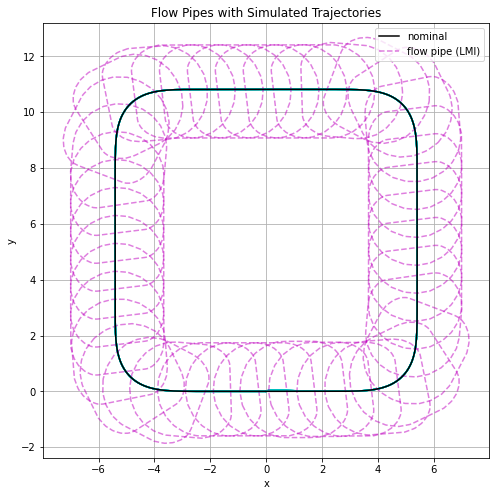

In [86]:
# large disturbance
freq = [0.02, .04, .06, .08, .01, .03, .05, .07, .09]
res = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = 1
w2 = 1  
ref = SE_Dist.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol_s, use_approx=False)
y_vect = ref['y']
x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]

init_e = array([[0, 0, -pi/10]]).T 
V0 = init_e.T@sol['P']@init_e
for i in freq:
    r = SE_Dist.simulate(40, i, w1, w2, init_e[0], init_e[1], init_e[2], dist='maxdV', sol= sol1, use_approx=False)
    SE_Dist.plot_simulated(r, color='c', name='sine wave', legend=True, save=False)
    res.append(r)
                
e0 = se2_log(init_e.reshape(3,))
print(e0)
flow_pipes_LMI, intervalhull_LMI, nom = flowpipes2(x_r, y_r, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='m', linestyle='--', alpha = 0.5)
    
h_nom = plt.plot(nom[:,0], nom[:,1], color='k', linestyle='-')

plt.axis('equal')
title('Flow Pipes with Simulated Trajectories')
xlabel('x')
ylabel('y')
legend([h_nom[0], hs_ch_LMI[0]], ['nominal', 'flow pipe (LMI)'], loc=1);

# Application Example

In [97]:
V2 = np.array([[1, 0], [-1, 0], [0, -1], [0, 1]])
P2 = Polytope(V2)
p4 = (4, 6)
P3 = P2*1.5 + (0,8.5)
P4 = P2 + p4
rot_mat5 = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)],
                     [np.sin(np.pi/4), np.cos(np.pi/4)]])
P5 = 0.5*rot_mat5*P3 -(1, 0)

[[ 0.1       ]
 [-0.1       ]
 [-0.31415927]]
[ 0.11488414 -0.08346821 -0.31415927]
[[ 9.50000000e-01  3.90953510e-10]
 [ 1.96912471e-18 -1.18614540e-09]
 [-5.79923527e-25  3.49329638e-16]
 [ 9.50000000e-01  1.57709926e-09]
 [ 9.50000000e-01  3.90953510e-10]]
0.9499999999999995
0.0
[[ 1.95000000e+00  1.00144208e-05]
 [ 1.00000000e+00 -1.35256927e-05]
 [ 1.00000000e+00  4.04139293e-09]
 [ 1.95000000e+00  2.35441549e-05]
 [ 1.95000000e+00  1.00144208e-05]]
0.9499999957137
0.0
[[ 2.94999211e+00  2.16217955e-03]
 [ 2.00000563e+00 -1.44917503e-03]
 [ 1.99999999e+00  3.23024659e-05]
 [ 2.94998648e+00  3.64365705e-03]
 [ 2.94999211e+00  2.16217955e-03]]
0.9499864806388123
0.0044721396817777506
[[ 3.94751265  0.05839586]
 [ 3.00153298 -0.01547079]
 [ 2.99998049  0.0044113 ]
 [ 3.94596016  0.07827795]
 [ 3.94751265  0.05839586]]
0.9459796705998533
0.07786567135222817
[[4.86726365 0.43906508]
 [4.02356523 0.02923528]
 [3.99499453 0.0880525 ]
 [4.83869295 0.4978823 ]
 [4.86726365 0.43906508]]
0.8

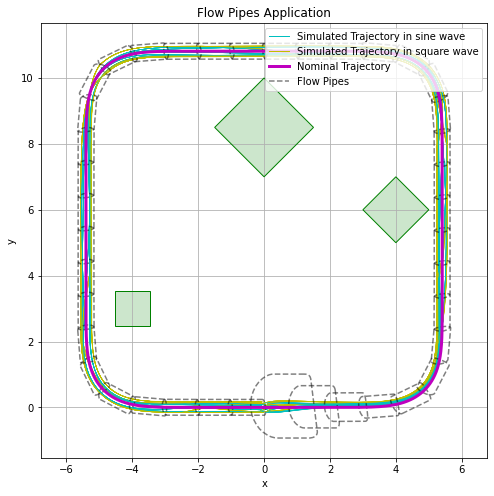

In [99]:
freq = [0.02, .04, .06, .08, .01]
res = []
e = []
V = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = .1
w2 = .1  
ref = SE_Dist.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol_s, use_approx=False)
y_vect = ref['y']
x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]

for theta0 in np.linspace(-pi/10, pi/10, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
                init_e = array([[x0, y0, theta0]]).T
                V0 = init_e.T@sol['P']@init_e
                V.append(V0)
                e.append(init_e)
                for i in freq:
                    r = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='sine', sol= sol_s, use_approx=False)
                    r2 = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='square', sol= sol_s, use_approx=False)
                    res.append(r)
                    if theta0 == np.pi/10 and x0 == .1 and y0 == .1 and i == freq[-1]:
                        SE_Dist.plot_simulated(r, name='sine wave', legend=True, save=False, linewidth = 1, color = 'c')
                        SE_Dist.plot_simulated(r2, name='square wave', legend=True, save=False, linewidth = 1, color = 'y')
                    else:
                        SE_Dist.plot_simulated(r, name='', legend=False, save=False, linewidth = .5, color = 'c')
                        SE_Dist.plot_simulated(r2, name='', legend=False, save=False, linewidth = .5, color = 'y')
                
i = np.array(V).argmax()
print(e[i])
e0 = se2_log(array(e[i]).reshape(3,))
print(e0)

flow_pipes_LMI, intervalhull_LMI, nom = flowpipes2(x_r, y_r, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.5)

P4.plot(facecolor=(0.8,.9,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,.9,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,.9,0.8), edgecolor='g', linewidth=1)


h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-', linewidth = 3)

plt.axis('equal')
title('Flow Pipes Application')
xlabel('x')
ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

[[ 0.1       ]
 [-0.1       ]
 [-0.31415927]]
[ 0.11488414 -0.08346821 -0.31415927]


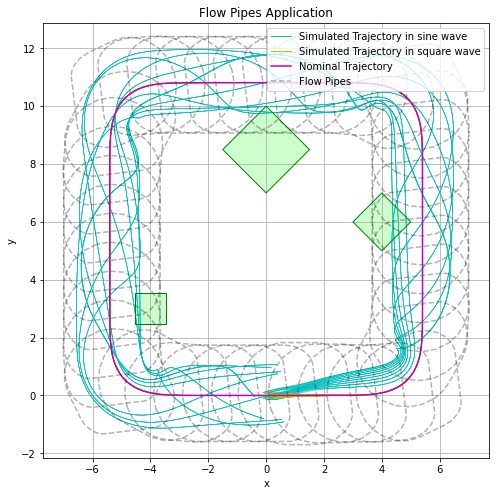

In [160]:
freq = [0.02, .04, .06, .08, .01, .03, .05, .07, .09]
res = []
e = []
V = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = 1
w2 = 1  
sol_l = find_se2_invariant_set(svd(3*pi/4))
ref = SE_Dist.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol_s, use_approx=False)
y_vect = ref['y']
x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]

for theta0 in np.linspace(-pi/10, pi/10, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
                init_e = array([[x0, y0, theta0]]).T
                V0 = init_e.T@sol['P']@init_e
                V.append(V0)
                e.append(init_e)
                for i in freq:
                    r = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='sine', sol= sol_l, use_approx=False)
                    r2 = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='maxdV', sol= sol_l, use_approx=False)
                    res.append(r)
                    if theta0 == np.pi/10 and x0 == .1 and y0 == .1 and i == freq[-1]:
                        SE_Dist.plot_simulated(r, name='sine wave', legend=True, save=False, linewidth = 1, color = 'c')
                        SE_Dist.plot_simulated(r2, name='square wave', legend=True, save=False, linewidth = 1, color = 'y')
                    else:
                        SE_Dist.plot_simulated(r, name='', legend=False, save=False, linewidth = .5, color = 'c', alpha = 0.5)
                        SE_Dist.plot_simulated(r2, name='', legend=False, save=False, linewidth = .5, color = 'y', alpha = 0.5)
                
i = np.array(V).argmax()
print(e[i])
e0 = se2_log(array(e[i]).reshape(3,))
print(e0)

flow_pipes_LMI, intervalhull_LMI, nom = flowpipes(x_r, y_r, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.3)

P4.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)


h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-')

plt.axis('equal')
title('Flow Pipes Application')
xlabel('x')
ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

In [ ]:
B = eye(3)
C = eye(3)
D = zeros((3,3))
sys = control.ss(Ap,B,C,D)
mag, phase, omega = control.freqresp(sys, logspace(-2,2,100))
#i_h_inf_norm = mag.argmax()
#omega_h_inf_norm = omega[i_h_inf_norm]
h_inf_norm = mag.max()
h_inf_norm

In [ ]:
from math import pi, cos, sin, sqrt
from pyobb.obb import OBB

# creates a lat/lon sphere with a given radius and centered at a given point
def sphere(radius, center, num_slices=30):
    theta_step = 2.0 * pi / (num_slices - 1)
    phi_step = pi / (num_slices - 1.0)
    theta = 0.0
    vertices = []
    for i in range(0, num_slices):
        cos_theta = cos(theta)
        sin_theta = sin(theta)
        phi = 0.0
        for j in range(0, num_slices):
            x = -sin(phi) * cos_theta
            y = -cos(phi)
            z = -sin(phi) * sin_theta
            n = sqrt(x * x + y * y + z * z)
            if n < 0.99 or n > 1.01:
                x /= n
                y /= n
                z /= n
            vertices.append((x * radius + center[0],
                             y * radius + center[1],
                             z * radius + center[2]))
            phi += phi_step
        theta += theta_step
    return vertices

obb = OBB.build_from_points(sphere(1, (0, 0, 0)))

In [14]:
def flowpipes3d(res, points, tf, n):
    t_vect = np.arange(0, tf, 0.05)
    
    y_vect = res['y']
    x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]
    
    y = array([x_r,y_r]).T
    
    nom = np.append(y,zeros((y.shape[0],1)), axis = 1) # n*3 (x-y direction) ###########
    
    # bound 
    #theta_circ = np.linspace(0, 2*np.pi, 30)
    #circ = array([1.5*np.cos(theta_circ), 1.5*np.sin(theta_circ), ones(30)]).T # circle in 3D
    
    flowpipes = []
    intervalhull = []
    steps = int(len(t_vect)/n)
    
    for i in range(n):
        # get traj for certain fixed time interval
        nom_i = nom[steps*i:steps*(i+1),:] # steps*3
        
        # interval hull
        obb = OBB.build_from_points(nom_i)
        
        # minkowski sum
        P1 = Polytope(obb.points) # interval hull
        P2 = Polytope(points.T) # invariant set
        P = P1+P2 # sum
        
        p1_vertices = P1.V
        p_vertices = P.V
        flowpipes.append(p_vertices)
        intervalhull.append(p1_vertices)
        
    return flowpipes, intervalhull, nom

In [15]:
n2 = 40
flow_pipes3d_s, intervalhull_s, nom = flowpipes3d(ref,exp_points,t, n2)

Text(0.5, 0, 'y')

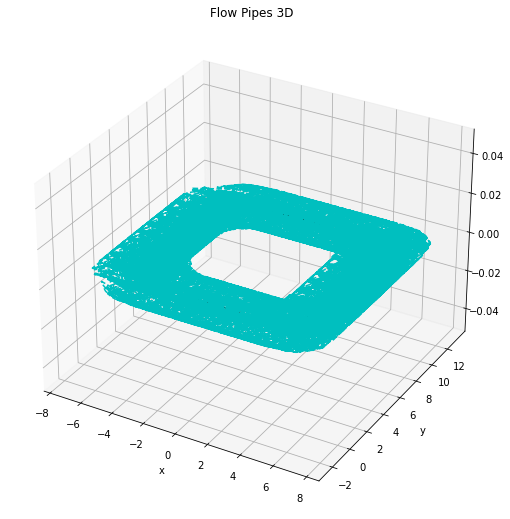

In [16]:
plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
h_nom = ax.plot3D(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n2):
    hs_ch_s = ax.plot3D(flow_pipes3d_s[facet][:,0], flow_pipes3d_s[facet][:,1], color='c', linestyle='--')

title('Flow Pipes 3D')
xlabel('x')
ylabel('y')